# **Classification Final Project: <br>Predicting the 2020 General Election Winner in US Counties**

# Project Objectives

This project will attempt to classify each county in the US based on which candidate in 2020 carried the majority vote in that county, based on various data about the county's demographics and economics. I will create models trained with and without results from previous election years. I will test and compare the results from using various classification techniques. I am going to be interested to see whether I can create better models than just predicting that each county would vote for the same party in 2020 as in 2016. 

Although I would like to get models that are good at predicting, I'm also interested in seeing what insights can be gleaned from the models, by seeing what features seem to be the most important, and by looking at misclassifications. This type of analysis is useful for politicians to know what factors are connected with one party or the other dominating in a locality.  

# Prepare Notebook Environment

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap, to_rgb


## Defining Functions

In [2]:
# Setting a random state so all models will use the same random state 
rs=24

In [3]:
# I'll use this to easily print out some key metrics for each model I create
def print_model_metrics(y_true, y_pred, model_name=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fbeta, support = precision_recall_fscore_support(y_true, y_pred,pos_label=0, average='binary')
    auc = roc_auc_score(y_true, y_pred)
    if model_name:
        model_metrics[model_name] = [accuracy, precision, recall, fbeta, auc]
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {fbeta:.2f}")
    print(f"AUC is: {auc:.2f}")

# Load Data

I searched online for compilations of county-level data set that include the election winners from 2020. I chose this one, which compiles data from a lot of different sources: https://www.kaggle.com/datasets/evangambit/us-county-data/data

Link to the exact data file:
https://raw.githubusercontent.com/evangambit/JsonOfCounties/master/counties.csv

In [4]:
filename='counties.csv'

In [5]:
county_df = pd.read_csv(filename)

In [6]:
county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Columns: 237 entries, name to industry/Mining, quarrying, and oil and gas extraction/employees
dtypes: float64(167), int64(67), object(3)
memory usage: 5.7+ MB


There are a lot of columns here! 237! I will not use all of these. 
Next, I'll check for null data:

In [7]:
county_df.isnull().sum()

name                                                                   0
fips                                                                   0
state                                                                  0
land_area (km^2)                                                       0
area (km^2)                                                            0
                                                                    ... 
industry/Management of companies and enterprises/employees          1867
industry/Industries not classified/payroll                          2328
industry/Industries not classified/employees                        2328
industry/Mining, quarrying, and oil and gas extraction/payroll      1778
industry/Mining, quarrying, and oil and gas extraction/employees    1778
Length: 237, dtype: int64

Even though this isn't showing all the data, I can tell that there are several columns with a lot of null data. Let me go ahead and print all of the columns just to see what I'm dealing with.

## Reduce Number of Columns

In [8]:
print(county_df.columns.tolist())

['name', 'fips', 'state', 'land_area (km^2)', 'area (km^2)', 'longitude (deg)', 'latitude (deg)', 'noaa/prcp', 'noaa/snow', 'noaa/temp', 'noaa/altitude', 'noaa/temp-jan', 'noaa/temp-apr', 'noaa/temp-jul', 'noaa/temp-oct', 'zip-codes', 'race/non_hispanic_white_alone_male', 'race/non_hispanic_white_alone_female', 'race/black_alone_male', 'race/black_alone_female', 'race/asian_alone_male', 'race/asian_alone_female', 'race/hispanic_male', 'race/hispanic_female', 'age/0-4', 'age/5-9', 'age/10-14', 'age/15-19', 'age/20-24', 'age/25-29', 'age/30-34', 'age/35-39', 'age/40-44', 'age/45-49', 'age/50-54', 'age/55-59', 'age/60-64', 'age/65-69', 'age/70-74', 'age/75-79', 'age/80-84', 'age/85+', 'male', 'female', 'population/2010', 'population/2011', 'population/2012', 'population/2013', 'population/2014', 'population/2015', 'population/2016', 'population/2017', 'population/2018', 'population/2019', 'deaths/suicides', 'deaths/firearm suicides', 'deaths/homicides', 'deaths/vehicle', 'bls/2004/labor_f

There are several different categories I can see here, so I'm going to create lists of columns to group those. Then I will probably drop a bunch of the categories to be a little more simple.

In [9]:
industrycols = [c for c in county_df.columns if c.startswith('industry')]

In [10]:
county_df[industrycols].isnull().sum()

industry/Construction/payroll                                                                    67
industry/Construction/employees                                                                  67
industry/Manufacturing/payroll                                                                  263
industry/Manufacturing/employees                                                                263
industry/Wholesale trade/payroll                                                                240
industry/Wholesale trade/employees                                                              240
industry/Retail trade/payroll                                                                    21
industry/Retail trade/employees                                                                  21
industry/Transportation and warehousing/payroll                                                 160
industry/Transportation and warehousing/employees                                               160


As I already knew, there are a lot of null entries in the industry category. While I'm sure there is still a lot of interesting information there, I'd rather just drop all the columns for now. 

In [11]:
healthcols = [c for c in county_df.columns if c.startswith('health')]

In [12]:
county_df[healthcols].isnull().sum()

health/% Fair or Poor Health                            1
health/Average Number of Physically Unhealthy Days      1
health/Average Number of Mentally Unhealthy Days        1
health/% Low birthweight                              106
health/% Smokers                                        1
health/% Adults with Obesity                            1
health/Food Environment Index                          20
health/% Physically Inactive                            1
health/% Excessive Drinking                             1
health/# Alcohol-Impaired Driving Deaths               35
health/Teen Birth Rate                                174
health/% Uninsured                                      2
health/% With Annual Mammogram                         21
health/% Vaccinated                                    19
health/% Children in Poverty                            2
health/80th Percentile Income                           2
health/20th Percentile Income                           2
health/% Child

Much fewer null columns in the health category. I'm still going to drop this category but might come back to look at this later.

In [13]:
educols = [c for c in county_df.columns if c.startswith('edu')]

In [14]:
county_df[educols].sample(5)

edu/less-than-high-school  edu/high-school  edu/some-college  \
2196                       10.1             35.6              34.0   
1289                       19.6             38.9              30.1   
2518                        7.4             21.2              28.1   
474                        18.7             38.9              31.8   
2585                       14.0             36.0              36.9   

      edu/bachelors+  
2196            20.3  
1289            11.4  
2518            43.3  
474             10.6  
2585            13.1

In [15]:
county_df[educols].isnull().sum()

edu/less-than-high-school    0
edu/high-school              0
edu/some-college             0
edu/bachelors+               0
dtype: int64

This category doesn't have a lot of columns and has no null values, so I'm keeping it.

In [16]:
covidcols  = [c for c in county_df.columns if c.startswith('covid')]

In [17]:
county_df[covidcols].sample(5)

covid-deaths/2020-02-01  covid-deaths/2020-03-01  \
1815                        0                        0   
2714                        0                        0   
390                         0                        0   
2290                        0                        0   
823                         0                        0   

      covid-deaths/2020-04-01  covid-deaths/2020-05-01  \
1815                        0                        4   
2714                        0                        2   
390                         0                        0   
2290                        2                       49   
823                         5                       32   

      covid-deaths/2020-06-01  covid-deaths/2020-07-01  \
1815                        7                       30   
2714                        2                        2   
390                         0                        0   
2290                       59                       63   
823                        50                       79   

      covid-deaths/2020-08-01  covid-deaths/2020-09-01  \
1815                       34                       38   
2714                        2                        7   
390                         5                        6   
2290                       64                       80   
823                       100                      142   

      covid-deaths/2020-10-01  covid-deaths/2020-11-01  ...  \
1815                       46                       55  ...   
2714                       19                       27  ...   
390                         8                       10  ...   
2290                       86                      112  ...   
823                       161                      179  ...   

      covid-vaccination/2021-03-01  covid-vaccination/2021-04-01  \
1815                          48.0                          48.8   
2714                          97.2                          96.8   
390                            0.0                           0.0   
2290                          99.0                          99.1   
823                           50.0                          50.3   

      covid-vaccination/2021-05-01  covid-vaccination/2021-06-01  \
1815                          50.0                          51.0   
2714                          95.8                          95.4   
390                            0.0                           0.0   
2290                          98.8                          98.8   
823                           48.6                          50.0   

      covid-vaccination/2021-07-01  covid-vaccination/2021-08-01  \
1815                          51.2                          51.3   
2714                          95.6                          95.6   
390                            0.0                           0.0   
2290                          98.8                          98.8   
823                           53.1                          54.1   

      covid-vaccination/2021-09-01  covid-vaccination/2021-10-01  \
1815                          51.3                          83.8   
2714                          95.6                          95.6   
390                            0.0                           0.0   
2290                          98.8                          98.7   
823                           55.5                          57.0   

      covid-vaccination/2021-11-01  covid-vaccination/2021-12-01  
1815                          82.6                          81.8  
2714                          95.7                          95.7  
390                           99.1                          99.1  
2290                          98.7                          98.7  
823                           58.0                          58.5  

[5 rows x 64 columns]

In [18]:
county_df[covidcols].isnull().sum().sum()

0

I'm going to drop these because there are so many columns, BUT there may actually be some really useful information there correlated with the election outcome in each county...

In [19]:
policeshootingcols = [c for c in county_df.columns if c.startswith('fatal_police_shootings')]

In [20]:
county_df[policeshootingcols].sample(5)

fatal_police_shootings/total-2017  fatal_police_shootings/unarmed-2017  \
323                                 0.0                                  0.0   
1038                                1.0                                  0.0   
1869                                0.0                                  0.0   
871                                 1.0                                  0.0   
2931                                1.0                                  0.0   

      fatal_police_shootings/firearmed-2017  \
323                                     0.0   
1038                                    0.0   
1869                                    0.0   
871                                     1.0   
2931                                    0.0   

      fatal_police_shootings/total-2018  fatal_police_shootings/unarmed-2018  \
323                                 1.0                                  0.0   
1038                                0.0                                  0.0   
1869                                0.0                                  0.0   
871                                 0.0                                  0.0   
2931                                2.0                                  1.0   

      fatal_police_shootings/firearmed-2018  \
323                                     1.0   
1038                                    0.0   
1869                                    0.0   
871                                     0.0   
2931                                    0.0   

      fatal_police_shootings/total-2019  fatal_police_shootings/unarmed-2019  \
323                            2.001175                                  0.0   
1038                           0.000000                                  0.0   
1869                           0.000000                                  0.0   
871                            0.000000                                  0.0   
2931                           2.000000                                  0.0   

      fatal_police_shootings/firearmed-2019  \
323                                0.001175   
1038                               0.000000   
1869                               0.000000   
871                                0.000000   
2931                               1.000000   

      fatal_police_shootings/total-2020  fatal_police_shootings/unarmed-2020  \
323                            1.000294                                  0.0   
1038                           0.000000                                  0.0   
1869                           0.000000                                  0.0   
871                            0.000000                                  0.0   
2931                           1.924977                                  0.0   

      fatal_police_shootings/firearmed-2020  
323                                1.000294  
1038                               0.000000  
1869                               0.000000  
871                                0.000000  
2931                               0.924977

In [21]:
county_df[policeshootingcols].isnull().sum()

fatal_police_shootings/total-2017        0
fatal_police_shootings/unarmed-2017      0
fatal_police_shootings/firearmed-2017    0
fatal_police_shootings/total-2018        0
fatal_police_shootings/unarmed-2018      0
fatal_police_shootings/firearmed-2018    0
fatal_police_shootings/total-2019        0
fatal_police_shootings/unarmed-2019      0
fatal_police_shootings/firearmed-2019    0
fatal_police_shootings/total-2020        0
fatal_police_shootings/unarmed-2020      0
fatal_police_shootings/firearmed-2020    0
dtype: int64

I'm so glad there are people keeping up with this data, but I'm going to leave it out of this project since I'm trimming columns

In [22]:
deathcols = [c for c in county_df.columns if c.startswith('death')]

In [23]:
electioncols = [c for c in county_df.columns if c.startswith('election')]

Now that I've made some gropus of columns, I'm going to create a reduced data frame by dropping a bunch of those categories:

In [24]:
reduced_df = county_df.drop(columns=policeshootingcols+covidcols+industrycols+healthcols+deathcols)

In [25]:
reduced_df.columns

Index(['name', 'fips', 'state', 'land_area (km^2)', 'area (km^2)',
       'longitude (deg)', 'latitude (deg)', 'noaa/prcp', 'noaa/snow',
       'noaa/temp', 'noaa/altitude', 'noaa/temp-jan', 'noaa/temp-apr',
       'noaa/temp-jul', 'noaa/temp-oct', 'zip-codes',
       'race/non_hispanic_white_alone_male',
       'race/non_hispanic_white_alone_female', 'race/black_alone_male',
       'race/black_alone_female', 'race/asian_alone_male',
       'race/asian_alone_female', 'race/hispanic_male', 'race/hispanic_female',
       'age/0-4', 'age/5-9', 'age/10-14', 'age/15-19', 'age/20-24',
       'age/25-29', 'age/30-34', 'age/35-39', 'age/40-44', 'age/45-49',
       'age/50-54', 'age/55-59', 'age/60-64', 'age/65-69', 'age/70-74',
       'age/75-79', 'age/80-84', 'age/85+', 'male', 'female',
       'population/2010', 'population/2011', 'population/2012',
       'population/2013', 'population/2014', 'population/2015',
       'population/2016', 'population/2017', 'population/2018',
       'populati

I'm going to stick with this set of columns for now. There's going to be some correlations between features, and some that I don't think will have a big effect, but it's a reasonable set of data to start with.

## Deal with Null Data

Let me see of my remaining data how much is null:

In [26]:
for col in reduced_df.columns:
    print(col, reduced_df[col].isnull().sum())

name 0
fips 0
state 0
land_area (km^2) 0
area (km^2) 0
longitude (deg) 0
latitude (deg) 0
noaa/prcp 0
noaa/snow 0
noaa/temp 0
noaa/altitude 0
noaa/temp-jan 0
noaa/temp-apr 0
noaa/temp-jul 0
noaa/temp-oct 0
zip-codes 0
race/non_hispanic_white_alone_male 0
race/non_hispanic_white_alone_female 0
race/black_alone_male 0
race/black_alone_female 0
race/asian_alone_male 0
race/asian_alone_female 0
race/hispanic_male 0
race/hispanic_female 0
age/0-4 0
age/5-9 0
age/10-14 0
age/15-19 0
age/20-24 0
age/25-29 0
age/30-34 0
age/35-39 0
age/40-44 0
age/45-49 0
age/50-54 0
age/55-59 0
age/60-64 0
age/65-69 0
age/70-74 0
age/75-79 0
age/80-84 0
age/85+ 0
male 0
female 0
population/2010 0
population/2011 0
population/2012 0
population/2013 0
population/2014 0
population/2015 0
population/2016 0
population/2017 0
population/2018 0
population/2019 0
bls/2004/labor_force 6
bls/2004/employed 6
bls/2004/unemployed 6
bls/2008/labor_force 6
bls/2008/employed 6
bls/2008/unemployed 6
bls/2012/labor_force 6
bls

**Drop Rows without Election Data**
This is just dropping 30 out of thousands of rows, and since this is going to be my target variable I have to drop them anyway.

In [27]:
reduced_df.dropna(subset=electioncols,inplace=True)

In [28]:
reduced_df.shape

(3112, 94)

In [29]:
reduced_df.isnull().sum().sum()

0

And it turns out that dropping those rows also dealt with my other null data! 

## Create Election Winner Columns

Since I want to do a classification project on which candidate carried the majority in each county, I'm going to convert the number of votes columns into a winner column for each election year:

In [30]:
reduced_df['elections/2020/gop']

0         3507.0
1        70092.0
2         1857.0
3         3544.0
4         4157.0
          ...   
3137     29818.0
3138    102636.0
3139      9745.0
3140     15722.0
3141     42001.0
Name: elections/2020/gop, Length: 3112, dtype: float64

I'm going to create election winner columns for each county based on whether the 'gop' or 'dem' column is greater for each election. In this process I'll go ahead and set 0 as 'dem' and 1 as 'gop'.

(Note that I could also do the percentage for one party or the other and treat this as a regression problem instead of classification, but for this project I'm going to do classification)

In [31]:
reduced_df['winner2008'] = np.where(reduced_df['elections/2008/dem'] > reduced_df['elections/2008/gop'], 0, 1)
reduced_df['winner2012'] = np.where(reduced_df['elections/2012/dem'] > reduced_df['elections/2012/gop'], 0, 1)
reduced_df['winner2016'] = np.where(reduced_df['elections/2016/dem'] > reduced_df['elections/2016/gop'], 0, 1)
reduced_df['winner2020'] = np.where(reduced_df['elections/2020/dem'] > reduced_df['elections/2020/gop'], 0, 1)

If I didn't know anything about this data set, I would also want to make sure that there aren't any ties here, where I would (in the code above) be giving all ties to the gop.

In [32]:
print(np.where(reduced_df['elections/2008/dem'] == reduced_df['elections/2008/gop'], 1, 0).sum())
print(np.where(reduced_df['elections/2012/dem'] == reduced_df['elections/2012/gop'], 1, 0).sum())
print(np.where(reduced_df['elections/2016/dem'] == reduced_df['elections/2016/gop'], 1, 0).sum())
print(np.where(reduced_df['elections/2020/dem'] == reduced_df['elections/2020/gop'], 1, 0).sum())

0
0
0
0


Okay good, nowhere was an exact tie so I can safely just use the labels 'dem' and 'gop' for the election winners. Now I'm going to remove the individual 'dem' and 'gop' columns. I'll keep the total columns for all years though.

Later I'll separate the 2020 winner column to use as my target.

# Exploratory Data Analysis

I have my reduced data set, but before I start building models, I want to make some plots and see what my data looks like. For example, how imbalanced is the target column?

Text(0.5, 0, '')

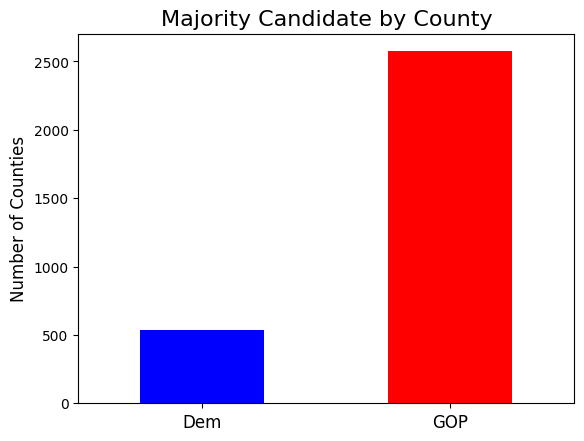

In [33]:
reduced_df['winner2020'].value_counts().sort_values(ascending=True).plot.bar(color=['blue', 'red'])
plt.ylabel('Number of Counties', fontsize=12)
plt.title('Majority Candidate by County', fontsize=16)
plt.xticks([0,1],labels=['Dem','GOP'], rotation=0, fontsize = 12)
plt.xlabel('')

**CAUTION: This does not mean that the GOP won the 2020 Election!** This is **number of counties**, not popular or electoral votes!

It's actually a pretty imbalanced data set! That's because this has one row per county, and while more people voted for the Democratic party (blue) in 2020, there are many low population counties that voted for the GOP (red). Just in case anyone is confused about the actual election result from 2020, though, we can easily check the popular vote (minus the 30 counties that for some reason had no data) by looking at the total vote columns:

Text(0.5, 1.0, 'Number of Votes per Candidate')

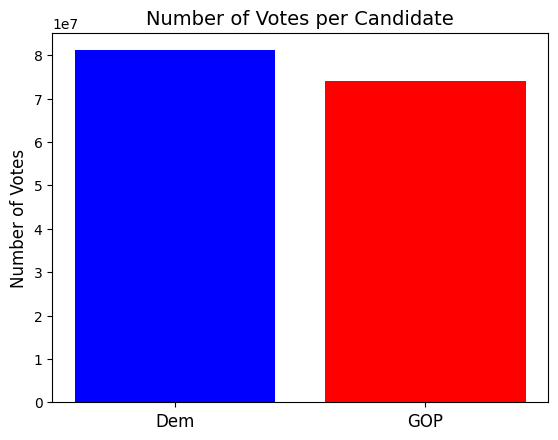

In [34]:
plt.bar(x=['Dem','GOP'], height=[reduced_df['elections/2020/dem'].sum(), reduced_df['elections/2020/gop'].sum()],color=['blue','red'])
plt.ylabel('Number of Votes', fontsize=12)
plt.xticks(fontsize=12)
plt.title('Number of Votes per Candidate', fontsize=14)

Okay good, our election data makes sense. But since I'm going to be predicting the counties instead of the total number of votes, I'm going to need to think about how to deal with the imbalance in the data set. I have a few options:
1. Ignore the imbalance and see what happens
2. Use stratified splitting to make sure that my training and testing columns have a reasonable proportion of each class
3. Upsample blue counties, downsample red counties, or some combination.
4. Use reweighting in my model creation

For now, I'm going to just use the stratified splitting but otherwise not worry about resampling, but I should come back to that later. For now I'll just remember that I might have some bias in my data towards predicting red.

In [35]:
selectedcols = ['population/2019','race/non_hispanic_white_alone_male',
       'race/non_hispanic_white_alone_female', 'race/black_alone_male',
       'race/black_alone_female', 'bls/2020/unemployed', 'avg_income', 'edu/less-than-high-school', 'edu/high-school', 'edu/some-college',
       'edu/bachelors+', 'winner2020']

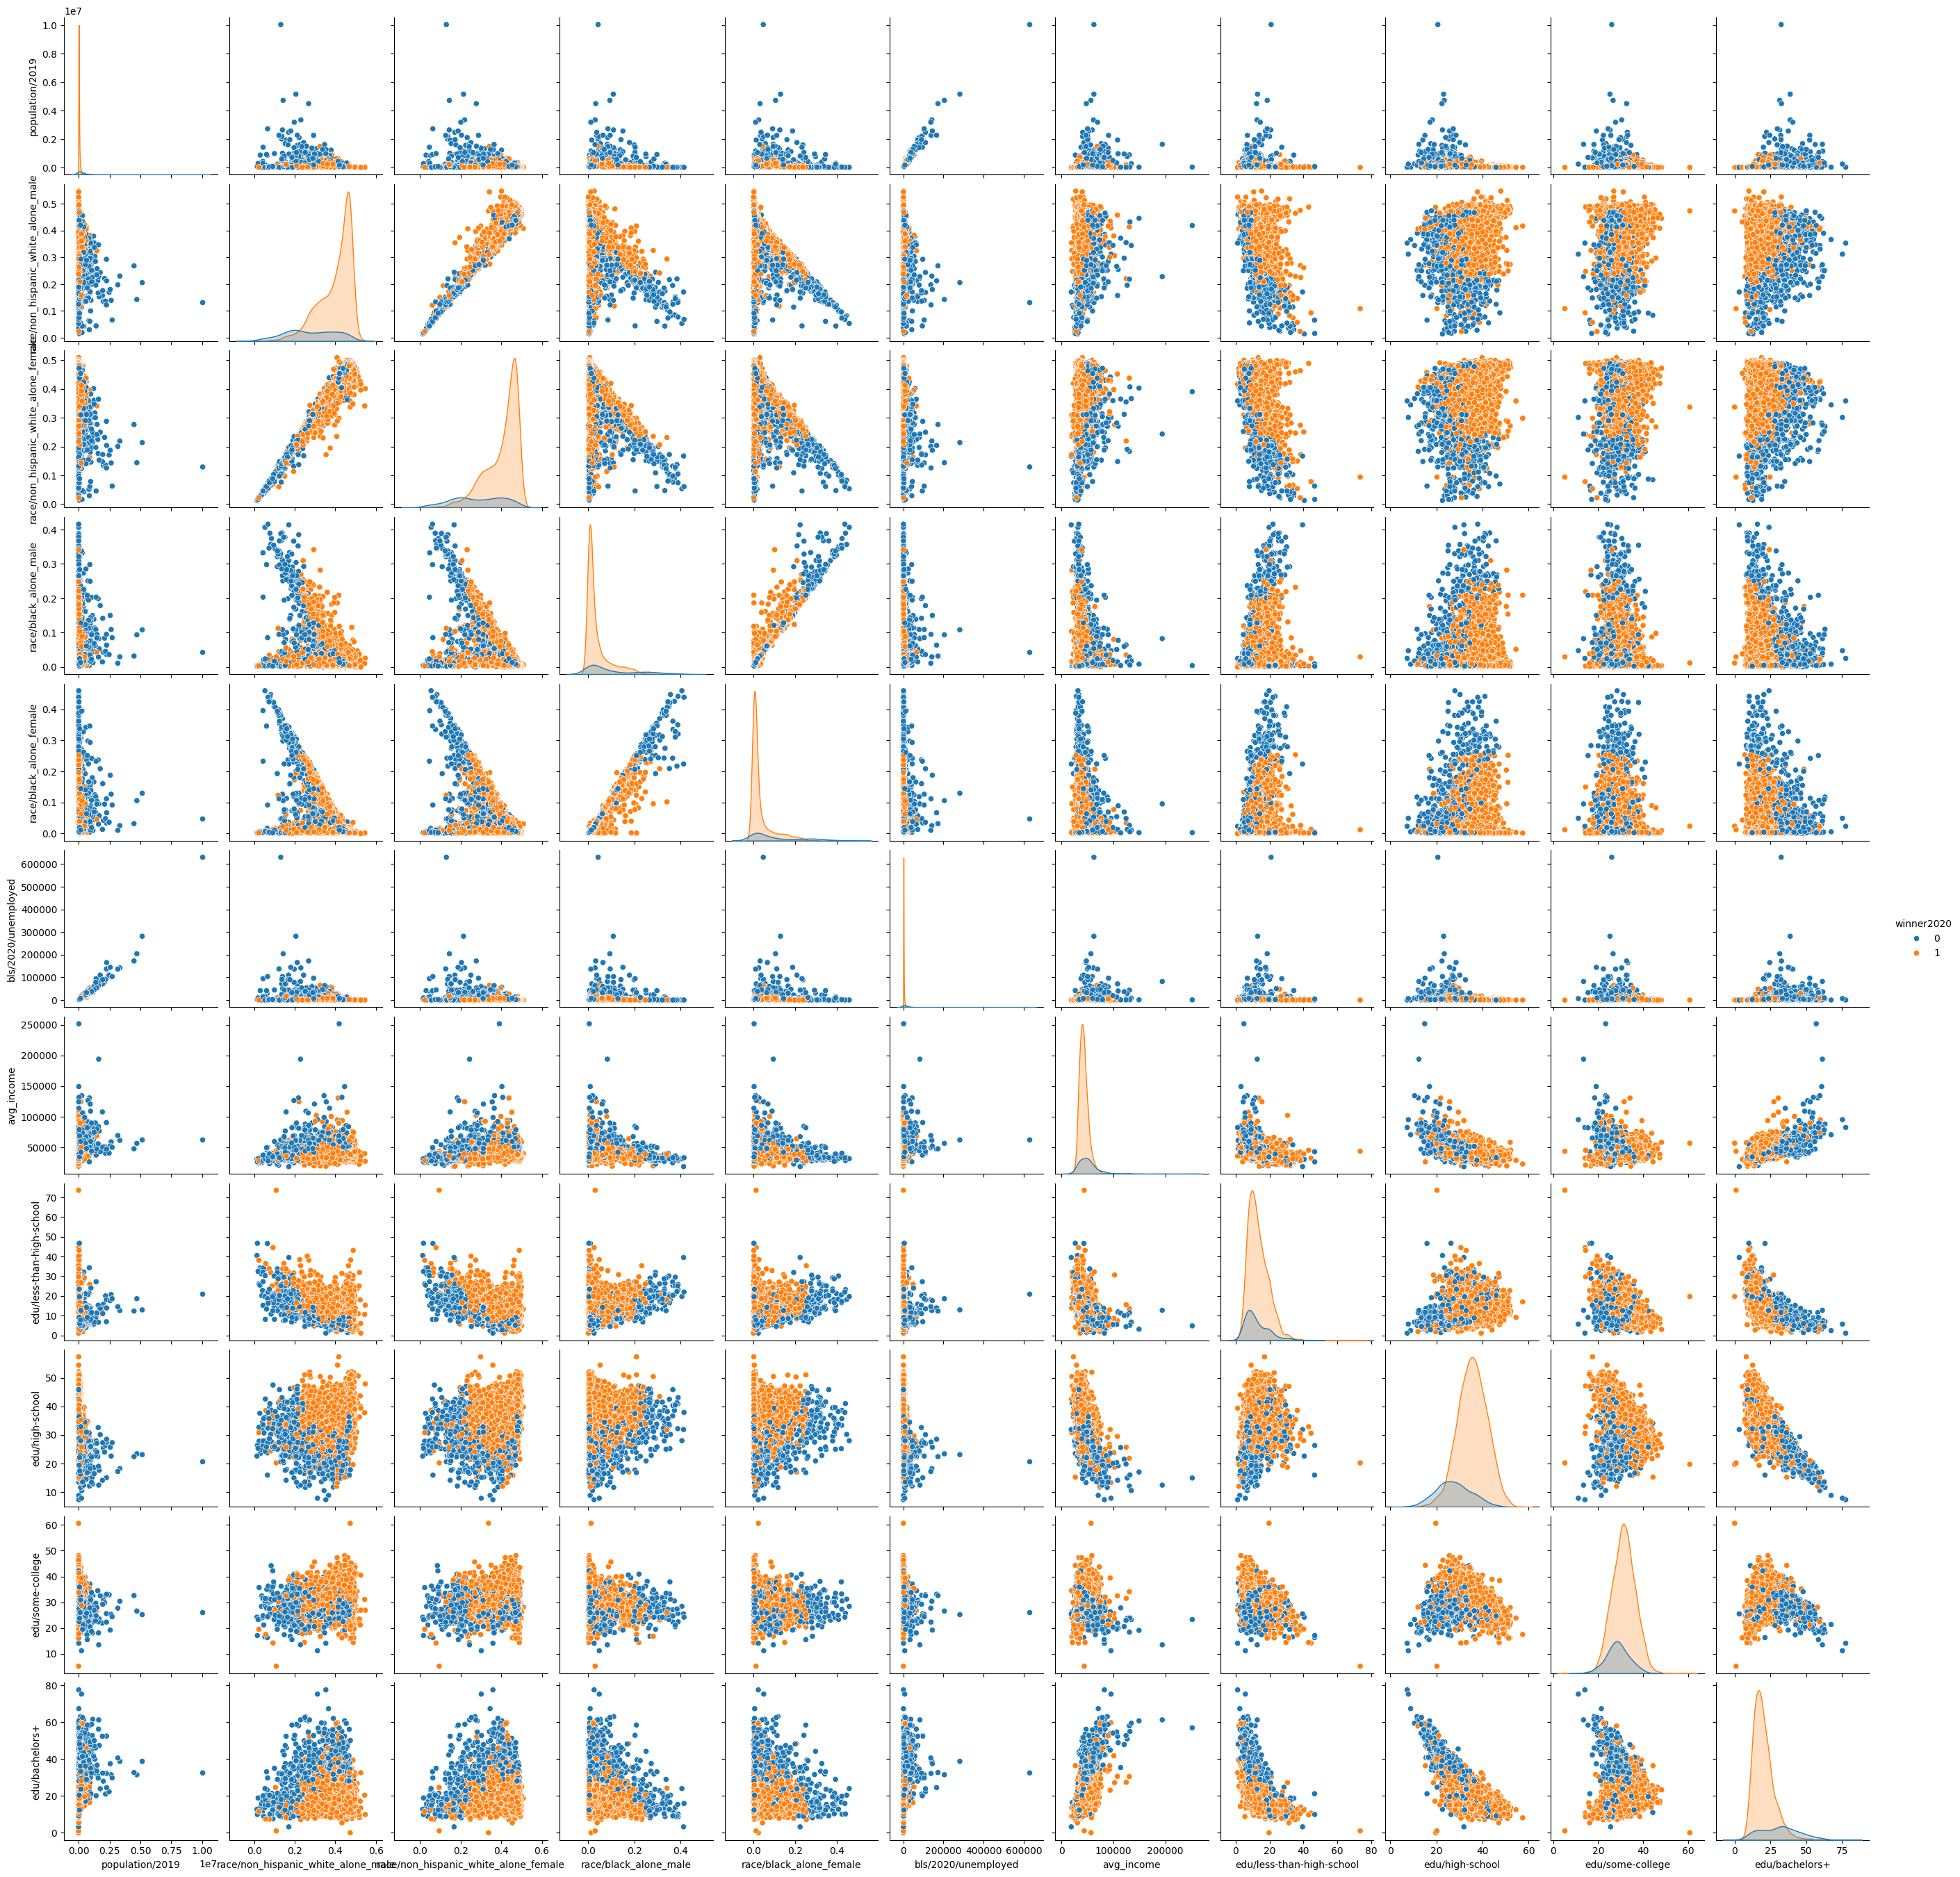

In [36]:
sns.pairplot(reduced_df[selectedcols], hue='winner2020')

We have a lot of variables that have non-surprising correlations. For example, the 'nonhispanic_white_alone_male' column is strongly positively correlated with the 'nonhispanic_white_alone_female' column. The 'less-than-high-school' column seems to be negatively correlated with the 'bachelors+' column. While none of this is surprising, it's important to keep in mind these interconnections when building and interpreting models.

And now looking at the colors, there definitely seem to be some general differences, so I do think these columns will be useful for predicting the 2020 election winners for the counties.

I'm going to look at a few plots showing how some of these variables are distributed among counties won by each party.

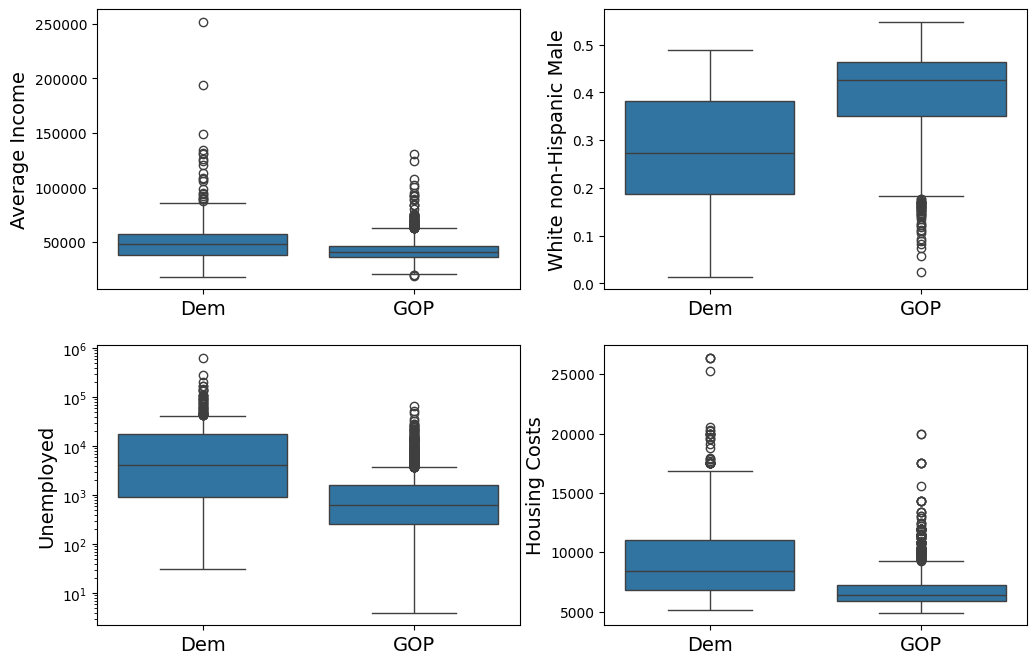

In [37]:
fig, axs = plt.subplots(2, 2, figsize=[12,8])
sns.boxplot(data = reduced_df, y='avg_income', x='winner2020', ax=axs[0][0])
axs[0][0].set_ylabel('Average Income',fontsize=14)

sns.boxplot(data = reduced_df, y='race/non_hispanic_white_alone_male', x='winner2020', ax=axs[0][1])
axs[0][1].set_ylabel('White non-Hispanic Male', fontsize=14)
sns.boxplot(data = reduced_df, y='bls/2020/unemployed', x='winner2020', ax=axs[1][0])
axs[1][0].set_ylabel('Unemployed', fontsize=14)
axs[1][0].set_yscale('log')
sns.boxplot(data = reduced_df, y='cost-of-living/housing_costs', x='winner2020', ax=axs[1][1])
axs[1][1].set_ylabel('Housing Costs',fontsize=14)

for ax in axs.flatten():
    ax.set_xlabel('')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Dem','GOP'],fontsize=14)

One thing I'm wondering is if my models will just copy whoever won previous elections to predict the future. I'm going to make a correlation heat map between the winners of these four elections to see how much they line up.

In [38]:
corr_matrix = reduced_df[['winner2008','winner2012','winner2016','winner2020']].corr()

<Axes: >

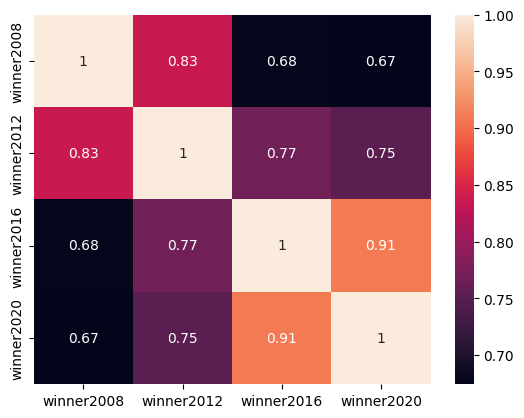

In [39]:
sns.heatmap(corr_matrix, annot=True)


Unsurprisingly very correlated. In my models I will look at: 

1. How well can I make a model predict 2020 *without* previous election columns?
2. Then how well with the election columns? Can I do any better than just copy+paste 2016?

Even if the best prediction is copying and pasting 2016, I still want to interpret what other factors are important in the models, so models with other features are still more interesting to me.

# Prepare training and testing data

I will create three feature sets: 
1. Including election winner columns from 2008, 2012, and 2016
2. Dropping these three election columns
3. Only including past election winners

Then I will split into stratified train and test sets, and scale my data.

In [40]:
X_with_elections = reduced_df.drop(columns=['elections/2008/dem', 'elections/2008/gop',
                            'elections/2012/dem', 'elections/2012/gop',
                            'elections/2016/dem', 'elections/2016/gop',
                            'elections/2020/dem', 'elections/2020/gop',
                            'winner2020', 'name','state','zip-codes','fips'])
X = X_with_elections.drop(columns=['winner2008','winner2012','winner2016'])
X_only_elections = reduced_df[['winner2008','winner2012','winner2016']]
y = reduced_df['winner2020']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)
X_train_with_elections, X_test_with_elections, y_train, y_test = train_test_split(
    X_with_elections, y, test_size=0.2, stratify=y, random_state = rs)
X_train_only_elections, X_test_only_elections, y_train, y_test = train_test_split(
    X_only_elections, y, test_size=0.2, stratify=y, random_state = rs)

In [42]:
(X_train.index!=X_train_with_elections.index).sum()

0

In [43]:
y_train.value_counts()

winner2020
1    2059
0     430
Name: count, dtype: int64

In [44]:
y_test.value_counts()

winner2020
1    515
0    108
Name: count, dtype: int64

Looks like I kept about the same ratio of the two classes in my training and testing set, and my training set rows are the same in the set with and without the election columns. 

Next I'll standardize the columns using the standard scaler:

In [45]:
scaler = StandardScaler()

In [46]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
X_train_elections_scaled = scaler.fit_transform(X_train_with_elections)
X_test_elections_scaled = scaler.transform(X_test_with_elections)

In [48]:
X_train_only_scaled = scaler.fit_transform(X_train_only_elections)
X_test_only_scaled = scaler.transform(X_test_only_elections)

# Build Classification Models

In this section, I'll build several different types of classification model. In each section, I'll do a simple implementation with the default parameters, then use GridSearchCV to tune the hyperparameters. 

## Copy Paste 2016

Now that I have a specific test set that I'm going to use from here on, I want to show what the error metrics on the simple model where I just predict that 2020 is a repeat of 2016.

I'm also going to create some data frames to collect information about all my models. Even though this isn't a machine learning model but just a basic guess, I'm going to include it as a baseline to see how the models compare.

I'll create two data frames: 

- One will be 'model_metrics', which will have a column for each row and then list the accuracy, precision, recall, F1 Score, and AUC.
- The other is called 'misclassified' will list all the counties, then for each model the row will be "True" if the county was misclassified, and "False" if it isn't.

In [49]:
model_metrics = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1Score', 'AUC'])

In [50]:
y_pred = X_test_with_elections['winner2016']
print_model_metrics(y_test,y_pred, model_name = 'Copy_2016')

Accuracy is: 0.98
Precision is: 0.98
Recall is: 0.88
Fscore is: 0.93
AUC is: 0.94


In [51]:
misclassified = reduced_df[['name','state']].loc[y_test.index]

In [52]:
misclassified

name state
1909    anderson county    TN
2072     suffolk county    NY
2806    beltrami county    MN
2287      shelby county    IN
1102      nevada county    AR
...                 ...   ...
2685  bennington county    VT
2438      valley county    ID
2898    billings county    ND
2648   vermilion county    IL
241     jim hogg county    TX

[623 rows x 2 columns]

Let me see which counties in the test set are misclassified.

In [53]:
misclassified['Copy2016'] = np.where(y_pred!=y_test, True, False)

misclassified[misclassified['Copy2016']==True]

name state  Copy2016
1445     chaffee county    CO      True
1731    chesapeake city    VA      True
2927   frederick county    MD      True
304      kleberg county    TX      True
1432     alamosa county    CO      True
2933      talbot county    MD      True
717   montgomery county    OH      True
2104  rensselaer county    NY      True
1134      marion county    OR      True
2598     kendall county    IL      True
2178        kent county    MI      True
2430       teton county    ID      True
1247      warren county    MS      True
2130    leelanau county    MI      True
319         hays county    TX      True

## Logistic Regression

First I'm going to just create a plain vanilla logistic regression model with the defaults just to see what happens! 

**Using only non-election features**

In [54]:
lrmodel = LogisticRegression(random_state=rs,max_iter=500)
lrmodel.fit(X_train_scaled, y_train)
y_pred = lrmodel.predict(X_test_scaled)

In [55]:
print_model_metrics(y_test, y_pred, model_name='Plain Logistic')

Accuracy is: 0.94
Precision is: 0.83
Recall is: 0.83
Fscore is: 0.83
AUC is: 0.90


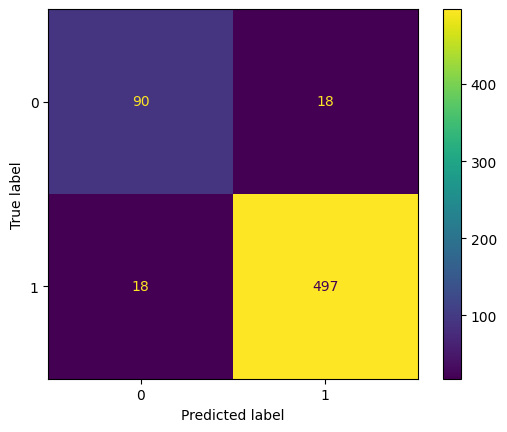

In [56]:
cf = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()

In [57]:
misclassified['Plain Logistic'] = np.where(y_pred!=y_test, True, False)

In [58]:
misclassified[(misclassified['Plain Logistic']==True)|(misclassified['Copy2016']==True)]

name state  Copy2016  Plain Logistic
2072     suffolk county    NY     False            True
2806    beltrami county    MN     False            True
1445     chaffee county    CO      True            True
2934    wicomico county    MD     False            True
1731    chesapeake city    VA      True           False
2109     niagara county    NY     False            True
998      portage county    WI     False            True
2927   frederick county    MD      True           False
304      kleberg county    TX      True            True
3092   penobscot county    ME     False            True
1432     alamosa county    CO      True            True
1510  pasquotank county    NC     False            True
1004  eau claire county    WI     False            True
2933      talbot county    MD      True            True
717   montgomery county    OH      True           False
3088   sagadahoc county    ME     False            True
2104  rensselaer county    NY      True           False
451     brewster county    TX     False            True
1134      marion county    OR      True           False
979    la crosse county    WI     False            True
2114    columbia county    NY     False            True
419    culberson county    TX     False            True
2682     rutland county    VT     False            True
2123      orange county    NY     False            True
403       collin county    TX     False            True
1232   issaquena county    MS     False            True
410       denton county    TX     False            True
764   tuscaloosa county    AL     False            True
1092       desha county    AR     False            True
2432      blaine county    ID     False            True
2598     kendall county    IL      True           False
242       dimmit county    TX     False            True
714       athens county    OH     False            True
2764    monmouth county    NJ     False            True
2178        kent county    MI      True           False
2037   jefferson parish    LA     False            True
143      harding county    NM     False            True
522       madera county    CA     False            True
2430       teton county    ID      True           False
244       brazos county    TX     False            True
1247      warren county    MS      True           False
2130    leelanau county    MI      True           False
2014   iberville parish    LA     False            True
2097      oneida county    NY     False            True
319         hays county    TX      True           False
2685  bennington county    VT     False            True
241     jim hogg county    TX     False            True

Some of the misclassified counties are the same but a lot are different. I'm going to keep adding to this misclassified data frame but I won't print it every time. I'll just come back to it at the end.

**Using all features, including previous elections**

In [59]:
lrmodel_with_elections = LogisticRegression(random_state=rs,max_iter=500)
lrmodel_with_elections.fit(X_train_elections_scaled, y_train)
y_pred = lrmodel_with_elections.predict(X_test_elections_scaled)

In [60]:
print_model_metrics(y_test, y_pred, model_name='Plain Logistic with elections')

Accuracy is: 0.96
Precision is: 0.89
Recall is: 0.90
Fscore is: 0.89
AUC is: 0.94


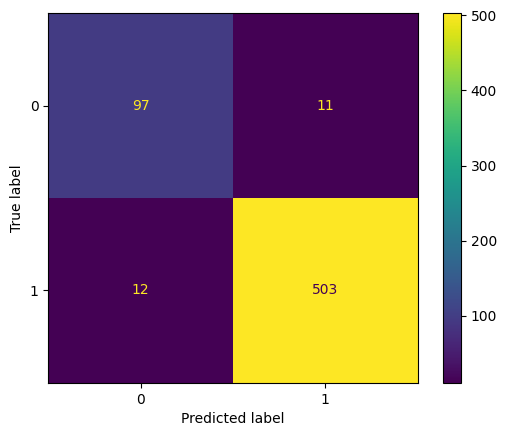

In [61]:
cf = confusion_matrix(y_test, y_pred) #, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()

In [62]:
misclassified['Plain Logistic with elections'] = np.where(y_pred!=y_test, True, False)

**Using only election columns**

In [63]:
lrmodel_only_elections = LogisticRegression(random_state=rs,max_iter=500)
lrmodel_only_elections.fit(X_train_only_scaled, y_train)
y_pred = lrmodel_only_elections.predict(X_test_only_scaled)
print_model_metrics(y_test, y_pred, model_name='Plain Logistic only elections')

Accuracy is: 0.98
Precision is: 0.98
Recall is: 0.88
Fscore is: 0.93
AUC is: 0.94


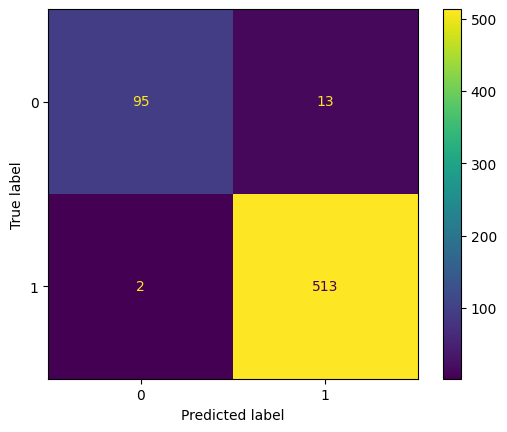

In [64]:
cf = confusion_matrix(y_test, y_pred) #, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()

So using just default logistic regression with no hyperparameter tuning or anything very fancy, here are the takeaways:
- Highest accuracy and precision are for only using previous election columns (2008, 2012, and 2016).
- However, recall gets a tiny bit better including all columns (it gets 2 more blue counties correctly labeled...although accuracy, precision, and F1score go down)
- From now on I'm going to just use the set with no election data and the set with all the features (skipping the set with only the election data because I'm really more interested in how the other features affect the elections)

In [65]:
misclassified['Plain Logistic only elections'] = np.where(y_pred!=y_test, True, False)

### Grid Search with Logistic Regression

In [66]:
def grid_search_lr(X_train, y_train):
    params_grid = {
        'class_weight': ['balanced', {0:0.5, 1:0.5}, {0:0.6, 1:0.4}, {0:0.75, 1:0.25}, {0:0.8, 1:0.2}],
        'penalty': ['l1','l2'],
        'solver': ['liblinear']
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=500)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    return grid_search

In [67]:
search_lr=grid_search_lr(X_train_scaled,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'class_weight': {0: 0.6, 1: 0.4}, 'penalty': 'l1', 'solver': 'liblinear'}


In [68]:
y_pred = search_lr.predict(X_test_scaled)

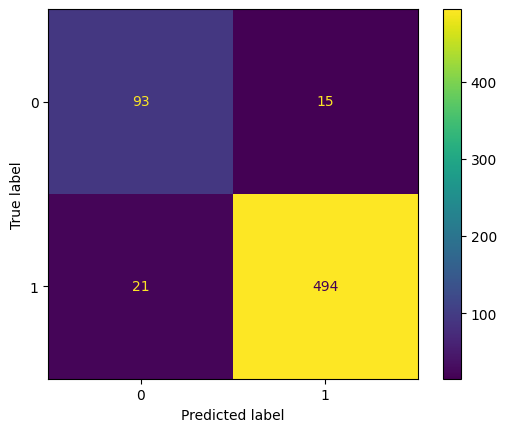

In [69]:
cf = confusion_matrix(y_test, y_pred) #, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()

In [70]:
print_model_metrics(y_test,y_pred, model_name='Logistic CV')

Accuracy is: 0.94
Precision is: 0.82
Recall is: 0.86
Fscore is: 0.84
AUC is: 0.91


In [71]:
print_model_metrics(y_train, search_lr.predict(X_train_scaled))

Accuracy is: 0.95
Precision is: 0.86
Recall is: 0.88
Fscore is: 0.87
AUC is: 0.93


Pretty similar between training and testing, training set a little better but not by a lot.

In [72]:
misclassified['Logistic CV'] = np.where(y_pred!=y_test, True, False)

**With Election Columns**

In [73]:
search_lr_with_elections=grid_search_lr(X_train_elections_scaled,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'class_weight': {0: 0.6, 1: 0.4}, 'penalty': 'l1', 'solver': 'liblinear'}


In [74]:
y_pred=search_lr_with_elections.predict(X_test_elections_scaled)

In [75]:
print_model_metrics(y_test, y_pred, model_name= 'Logistic CV with elections')

Accuracy is: 0.97
Precision is: 0.89
Recall is: 0.92
Fscore is: 0.90
AUC is: 0.95


Now we're talking! This is looking a bit better (though not really better than just copy paste 2016...)

In [76]:
misclassified['Logistic CV with elections'] = np.where(y_pred!=y_test, True, False)

### Logistic Regression Interpretation

Of my logistic regression models, the best one for my purposes are probably the ones chosen using the grid search. (Yes, the one using only the election results from previous years technically scored better, but that would not give me as many insights into the counties about why they tend to vote for those parties in the first place). 

I'll plot the coefficients of each to see what these models chose as important.

<Axes: ylabel='Feature'>

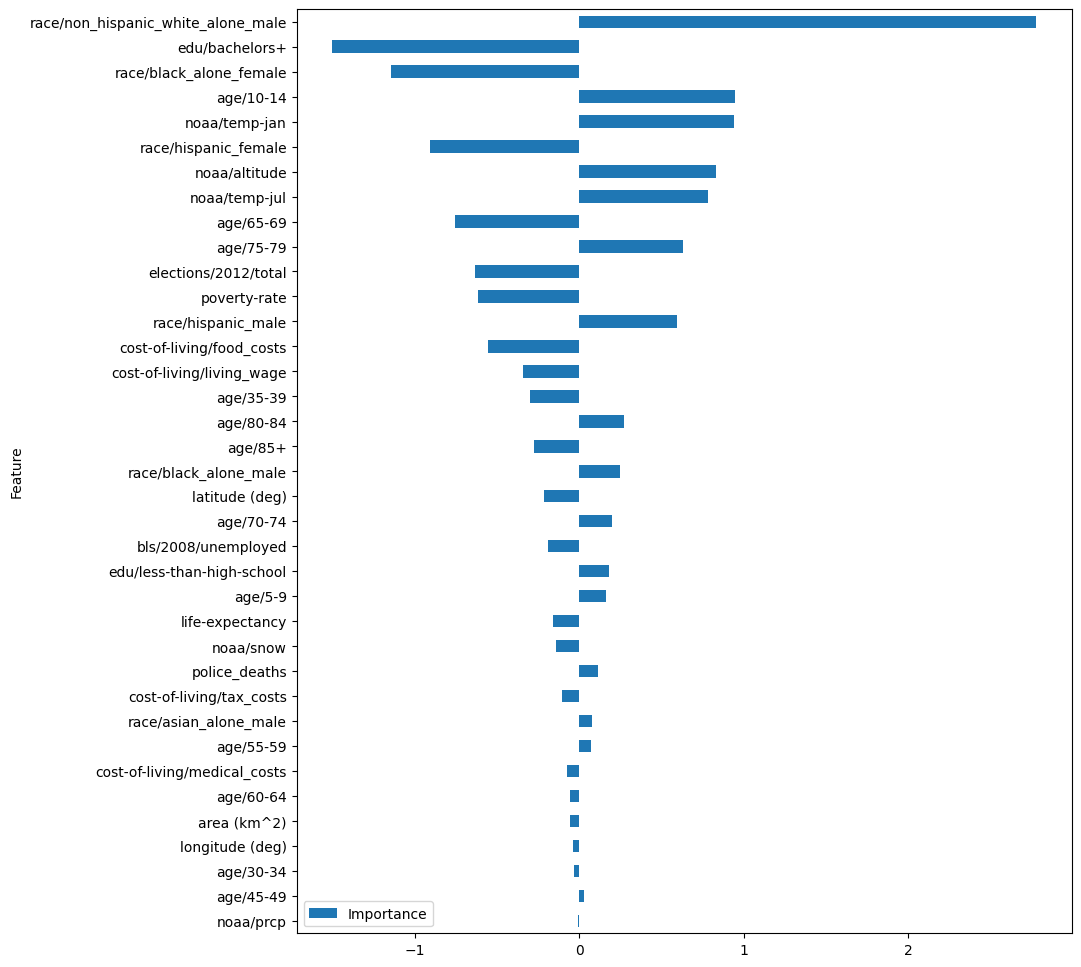

In [77]:
coefficients = search_lr.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns[abs(coefficients)>0], 'Importance': (coefficients[abs(coefficients)>0])})
feature_importance = feature_importance.sort_values('Importance', ascending=True, key=abs)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 12))

**Model Insights**

This plot shows positive coefficients to the right, negative to the left. Since my data has 0 as Democrat and 1 as Republican, that means that the coefficients on the left make the county predictions Dem, while coefficients on the right will make the model choose GOP.
- The top three coefficients make sense to me based on what I've heard about voting patterns in the USA. Race, gender, and education level are often cited as factors that tend to correlate with voting trends.
- I'm not sure why the age 10-14 ended up ranking higher than other ages, but I suppose it could also just be picking up on a correlation with the total population of the county? Or maybe counties that have more families with kids? Not sure what's happening there.
- Also interesting that the model picked out several NOAA features near the top. Those were columns I left in thinking that L1 regularization would toss out, but apparently this model thinks that the altitude and temperature are important!

<Axes: ylabel='Feature'>

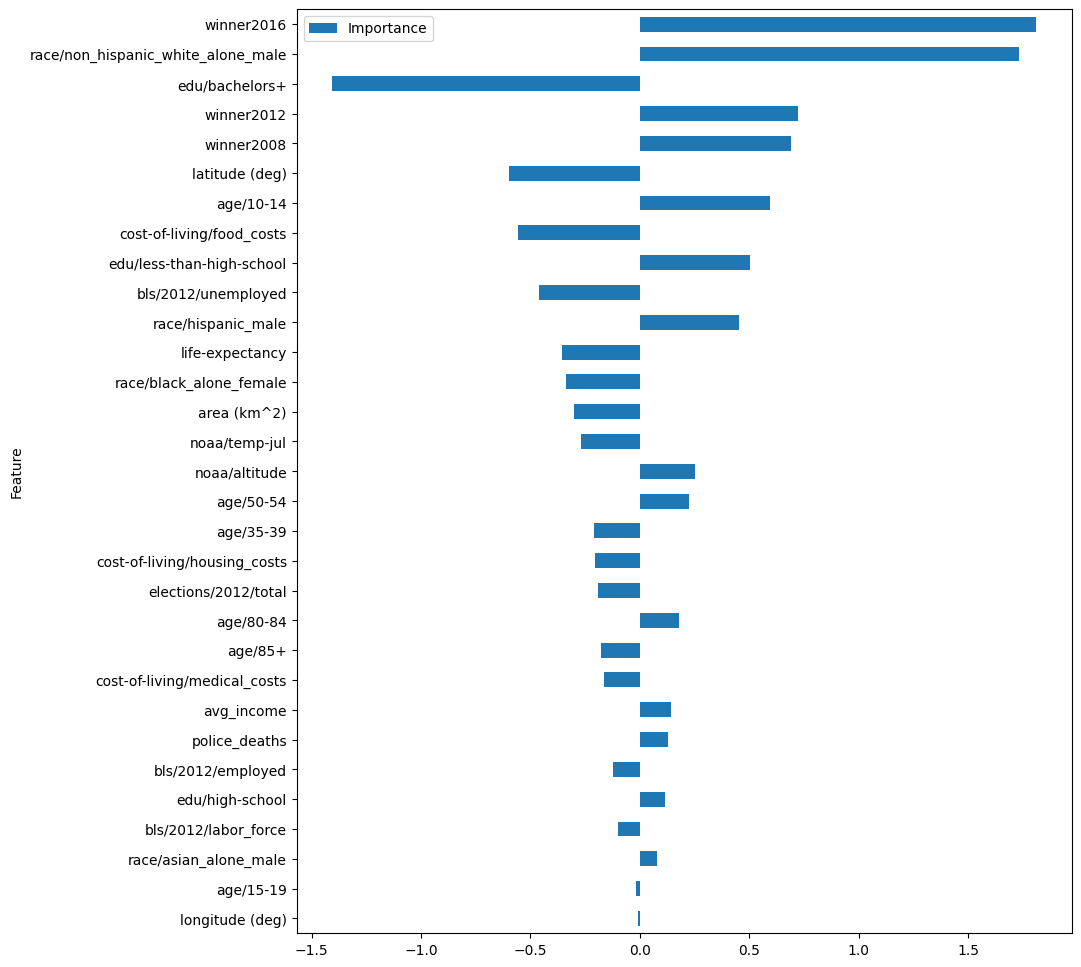

In [78]:
coefficients = search_lr_with_elections.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train_with_elections.columns[abs(coefficients)>0], 'Importance': (coefficients[abs(coefficients)>0])})
feature_importance = feature_importance.sort_values('Importance', ascending=True, key=abs)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 12))

**Model Insights**

- I'm actually a bit surprised that the three election winners weren't the top three columns! 2016 was first, which makes sense because it was the most similar to 2020 in time and one of the candidates. But then the white male and bachelor+ columns were actually higher than the next election columns!
- Latitude is pretty high up surprisingly, and then again we have age 10-14 (again with a positive coefficient, meaning this model will have counties with higher number of people aged 10-14 leaning to the right).

## Decision Tree

Simple decision tree , whatever default parameters, without election columns

In [79]:
dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train_scaled, y_train)
y_pred = dtmodel.predict(X_test_scaled)
print_model_metrics(y_test, y_pred, model_name='Decision Tree')

Accuracy is: 0.91
Precision is: 0.76
Recall is: 0.69
Fscore is: 0.72
AUC is: 0.82


In [80]:
misclassified['Decision Tree'] = np.where(y_pred!=y_test, True, False)

And with election columns:

In [81]:
dtmodel_with_elections = DecisionTreeClassifier()
dtmodel_with_elections.fit(X_train_elections_scaled, y_train)
y_pred = dtmodel_with_elections.predict(X_test_elections_scaled)
print_model_metrics(y_test, y_pred, model_name='Decision Tree with elections')

Accuracy is: 0.96
Precision is: 0.89
Recall is: 0.86
Fscore is: 0.88
AUC is: 0.92


In [82]:
misclassified['Decision Tree with Elections'] = np.where(y_pred!=y_test, True, False)

### Decision Tree Grid Search

In [83]:
def grid_search_dt(X_train, y_train):
    params_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5]
    }
    model = DecisionTreeClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = model, 
                        param_grid = params_grid, 
                        scoring='f1',
                        cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train.values.ravel())
    print(grid_search.best_params_)
    return grid_search

In [84]:
search_dt=grid_search_dt(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}


In [85]:
y_pred = search_dt.predict(X_test_scaled)
print_model_metrics(y_test, y_pred, model_name= 'Decision Tree CV')

Accuracy is: 0.93
Precision is: 0.84
Recall is: 0.73
Fscore is: 0.78
AUC is: 0.85


In [86]:
misclassified['Decision Tree CV'] = np.where(y_pred!=y_test, True, False)

In [87]:
search_dt_with_elections=grid_search_dt(X_train_elections_scaled, y_train)
y_pred = search_dt_with_elections.predict(X_test_elections_scaled)
print_model_metrics(y_test, y_pred, model_name='Decision Tree CV with elections')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2}
Accuracy is: 0.96
Precision is: 0.92
Recall is: 0.86
Fscore is: 0.89
AUC is: 0.92


In [88]:
misclassified['Decision Tree CV with elections'] = np.where(y_pred!=y_test, True, False)

### Decision Tree Model Interpretation

The model after running the grid search was the best on most of the metrics (if only by a little bit), so let's visualize that.

In [89]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True, fontsize=12, impurity=False)
    plt.show()

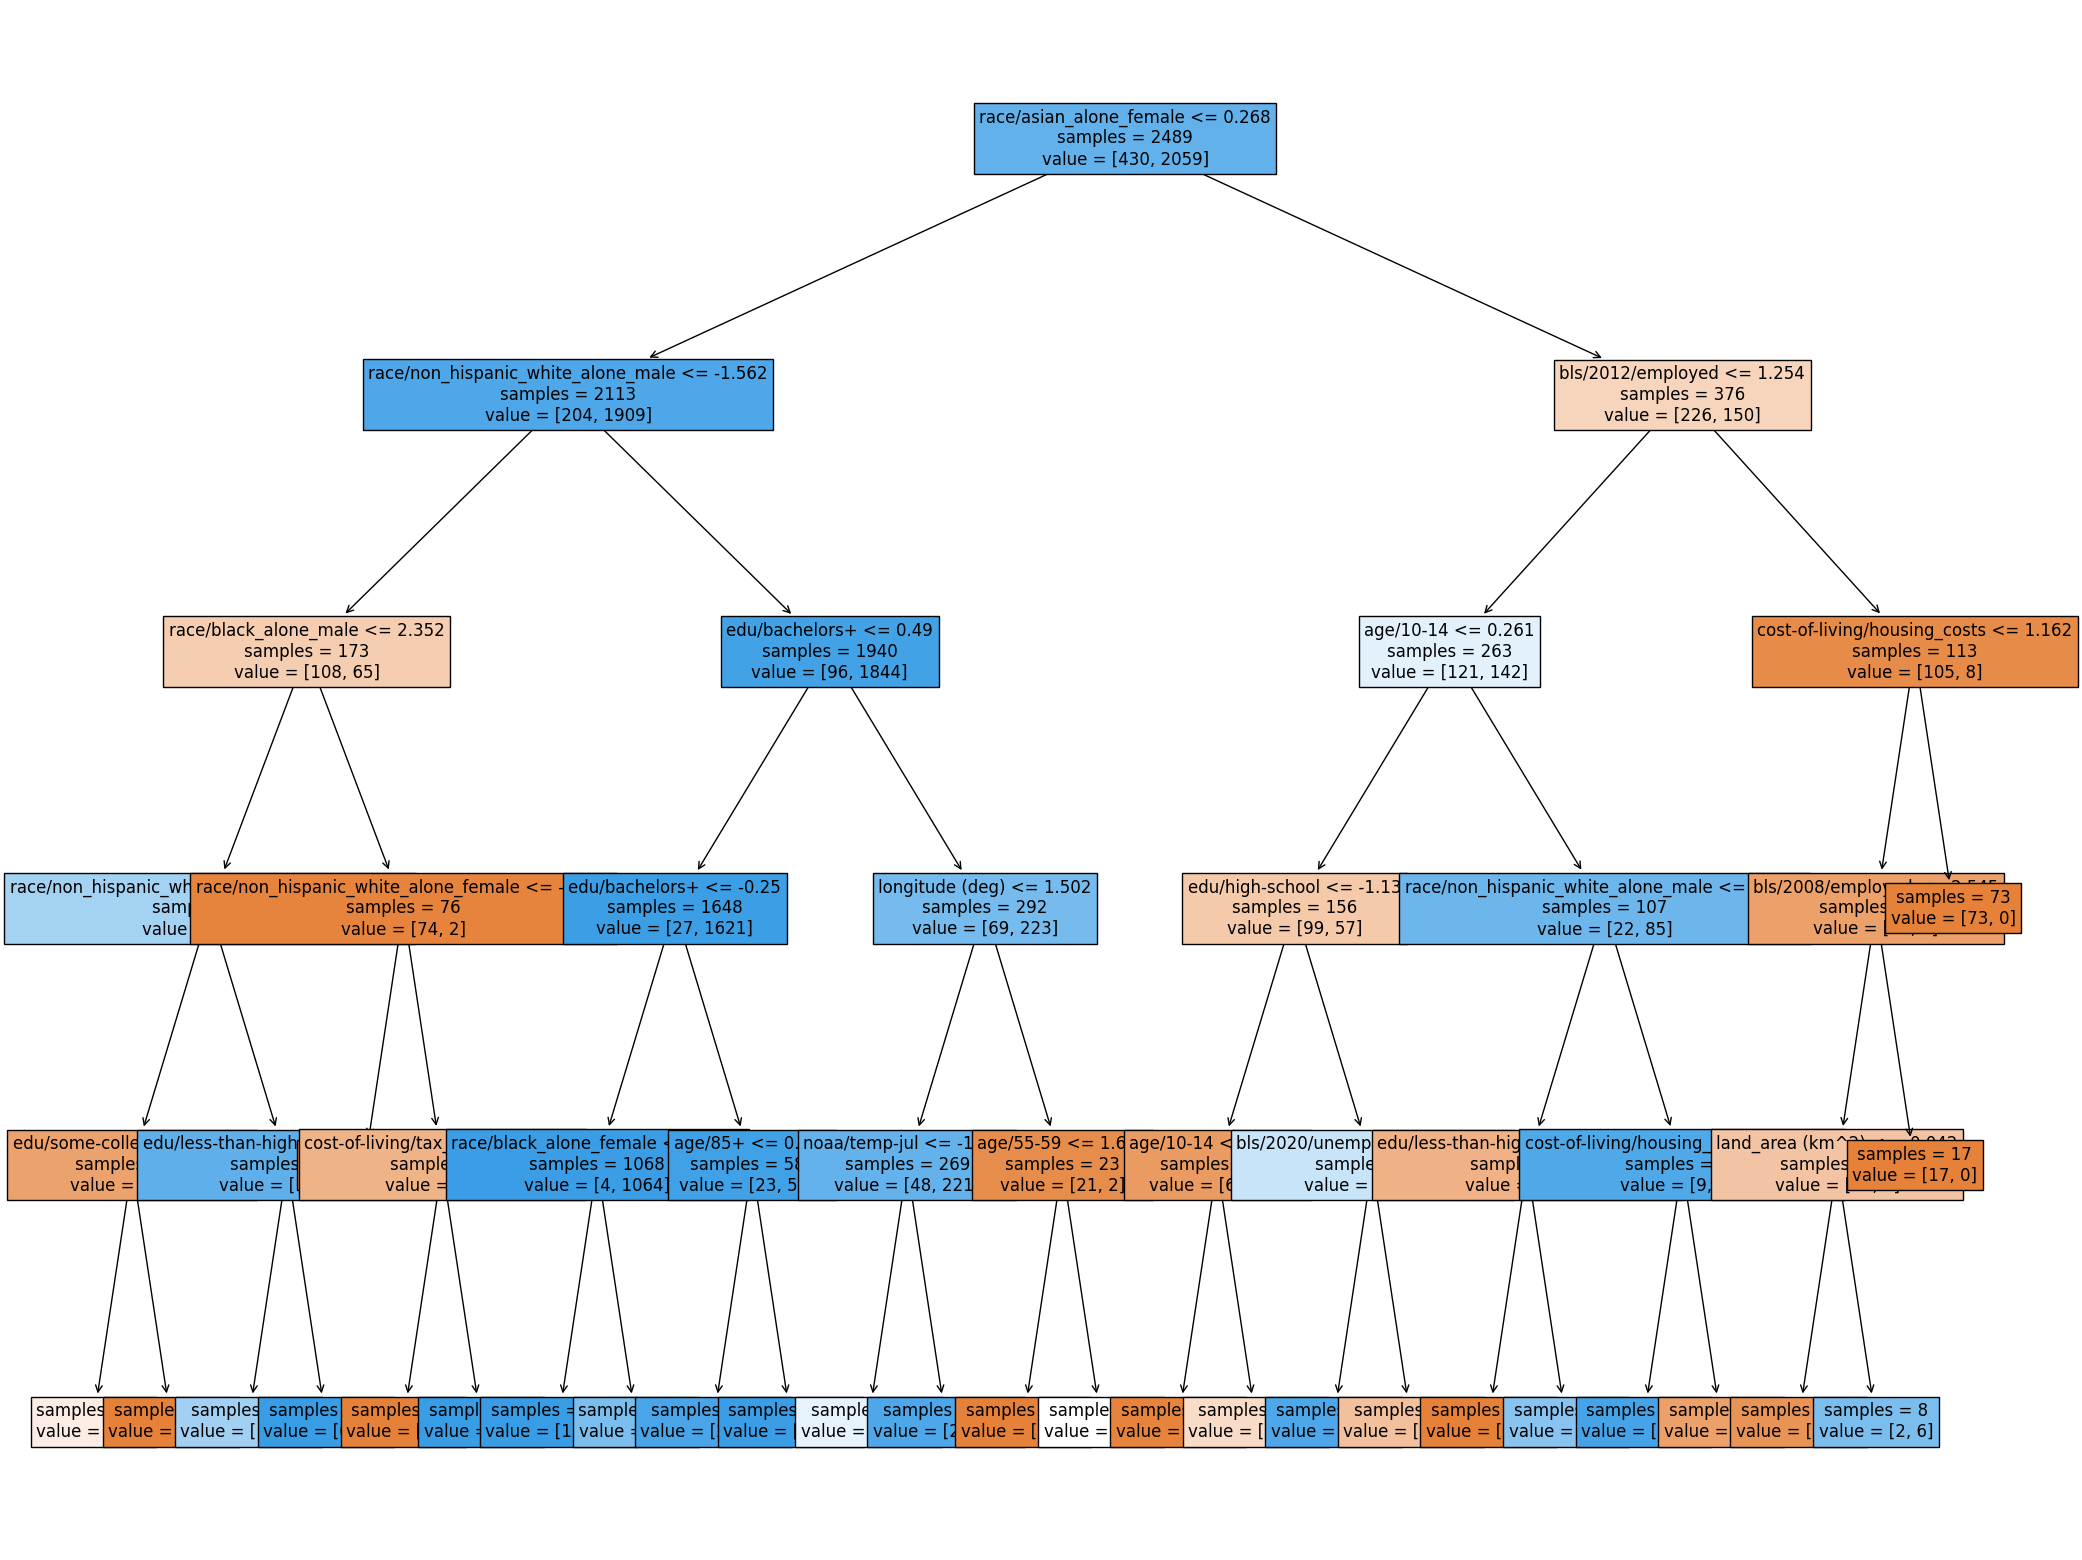

In [90]:
plot_decision_tree(search_dt.best_estimator_, X_test.columns)

**Model Insights**

- The max_depth=5 makes this really difficult to interpret! Trying to follow each split makes it easy for me to see how a model like this can end up being overfit.
- The first split chosen is based on Asian females (lower number-> more GOP, higher number->more Dem)? I find this surprising.
- I do see several other features I've seen show up before, though -- white male, age 10-14, bachelors+
- This is also a bit difficult to interpret because blue is 0 and red is 1, which means red is more democrat. This is backwards form what I'm used to thinking but I can't find an easy way to change the color here

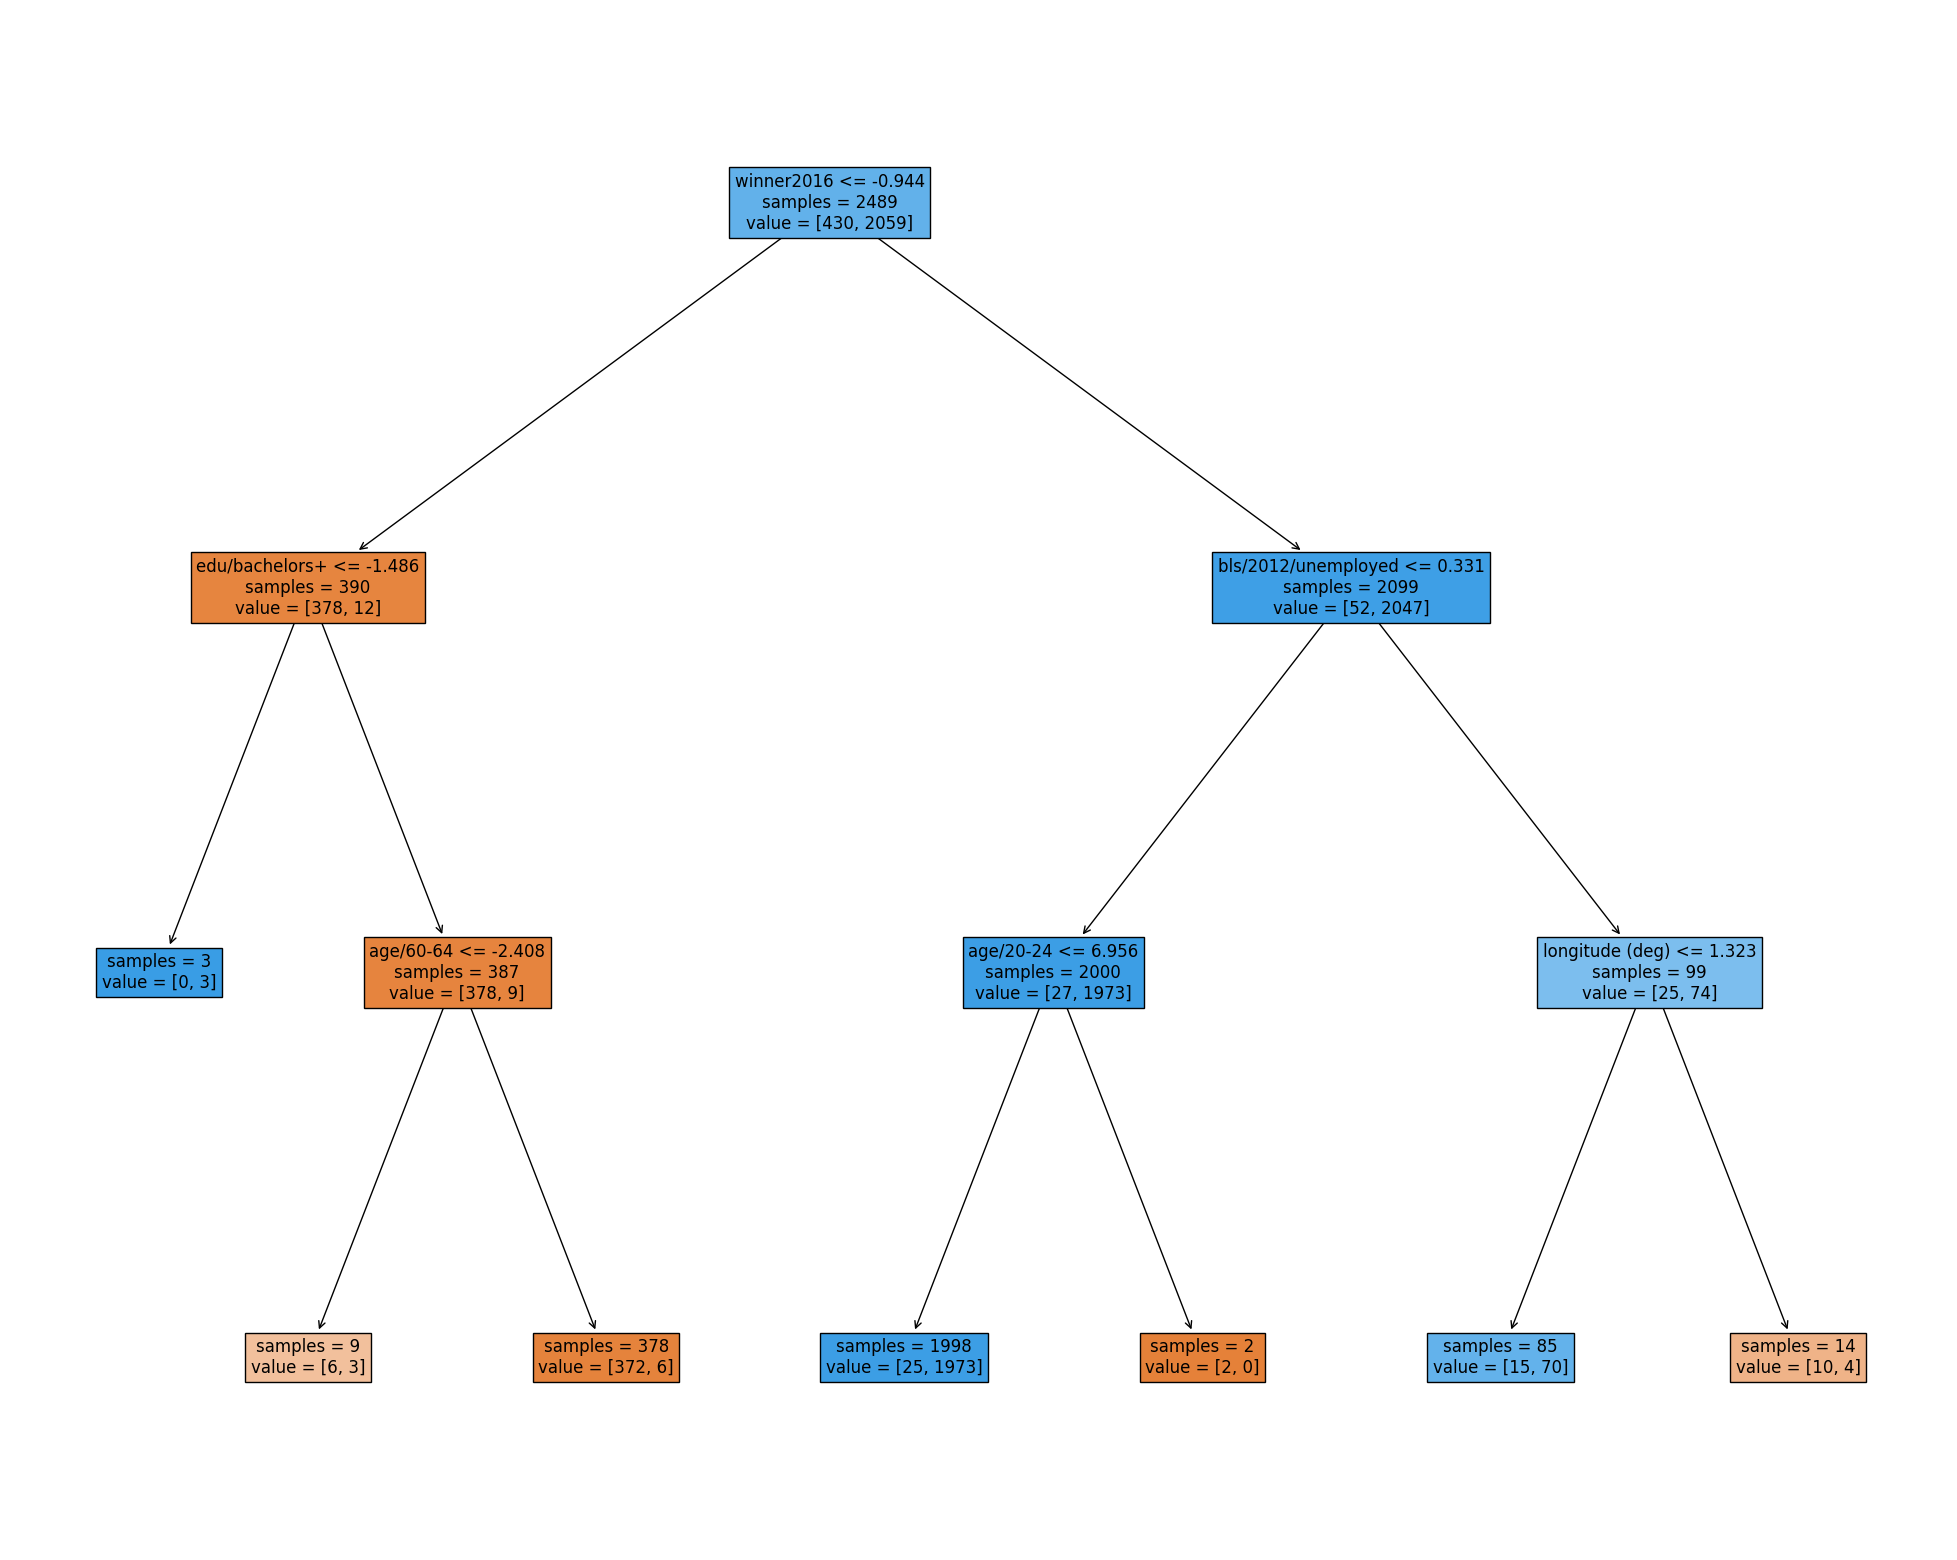

In [91]:
plot_decision_tree(search_dt_with_elections.best_estimator_, X_test_with_elections.columns)

**Model Insights**

- Fewer layers makes this model easier to follow
- For example, the first split 2016 election: if the county went to the Democrat candidate in 2016 (left split), but had a lower number of bachelors+ education, the county voted GOP in 2020 (left split). (This is just three samples of the training set, so it's hard to know if that's just very specifically overfit to those three counties)
- The other split on the left doesn't actually end up making any different classifications
- Besides that, this model has chosen unemployment, ages 20-24, and longitude. Interesting...

## Random Forest

In [92]:
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', {1:0.5, 0:0.5}, {1:0.1, 0:0.9}, {1:0.2, 0:0.8}, {1:0.3, 0:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    return grid_search

In [93]:
search_rf=grid_search_rf(X_train_scaled, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'class_weight': {1: 0.5, 0: 0.5}, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}


In [94]:
y_pred = search_rf.predict(X_test_scaled)

In [95]:
misclassified['Random Forest'] = np.where(y_pred!=y_test, True, False)

In [96]:
print_model_metrics(y_test, y_pred, model_name='Random Forest')

Accuracy is: 0.94
Precision is: 0.88
Recall is: 0.78
Fscore is: 0.82
AUC is: 0.88


In [97]:
print_model_metrics(y_train, search_rf.predict(X_train_scaled))

Accuracy is: 1.00
Precision is: 1.00
Recall is: 0.99
Fscore is: 1.00
AUC is: 1.00


Hmmm ok so the random forest grid search did not do all that well on this data! Decent accuracy but the other metrics aren't great. The training set metrics are a lot better than the test set, so I'm pretty sure there was some overfitting. I'll try with the election columns included.

**With Election Columns**

In [98]:
search_rf_withelections=grid_search_rf(X_train_elections_scaled, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'class_weight': {1: 0.5, 0: 0.5}, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [99]:
y_pred = search_rf_withelections.predict(X_test_elections_scaled)
print_model_metrics(y_test, y_pred, model_name='Random Forest with Elections')

Accuracy is: 0.97
Precision is: 0.93
Recall is: 0.92
Fscore is: 0.93
AUC is: 0.95


This is quite a bit better!

In [100]:
misclassified['Random Forest with elections'] = np.where(y_pred!=y_test, True, False)

### Random Forest Model Interpretation

<Axes: ylabel='Feature'>

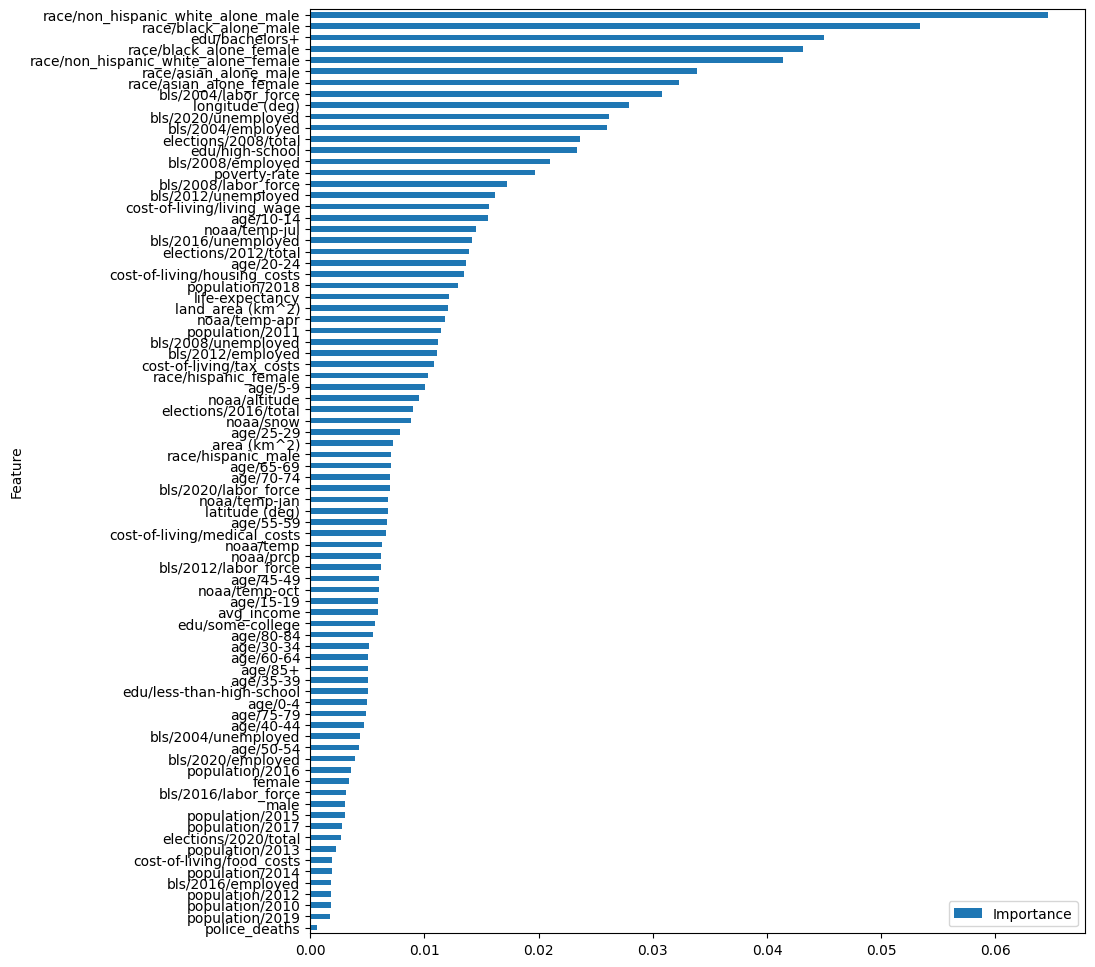

In [101]:
pd.DataFrame({'Feature':X_test.columns,
              'Importance':search_rf.best_estimator_.feature_importances_}).sort_values('Importance', ascending=True).plot(x='Feature', y='Importance', kind='barh', figsize=[10, 12])

Six of the top seven "important" features are the race/gender columns. And the eduction bachelors+ column takes the #3 spot. 

<Axes: ylabel='Feature'>

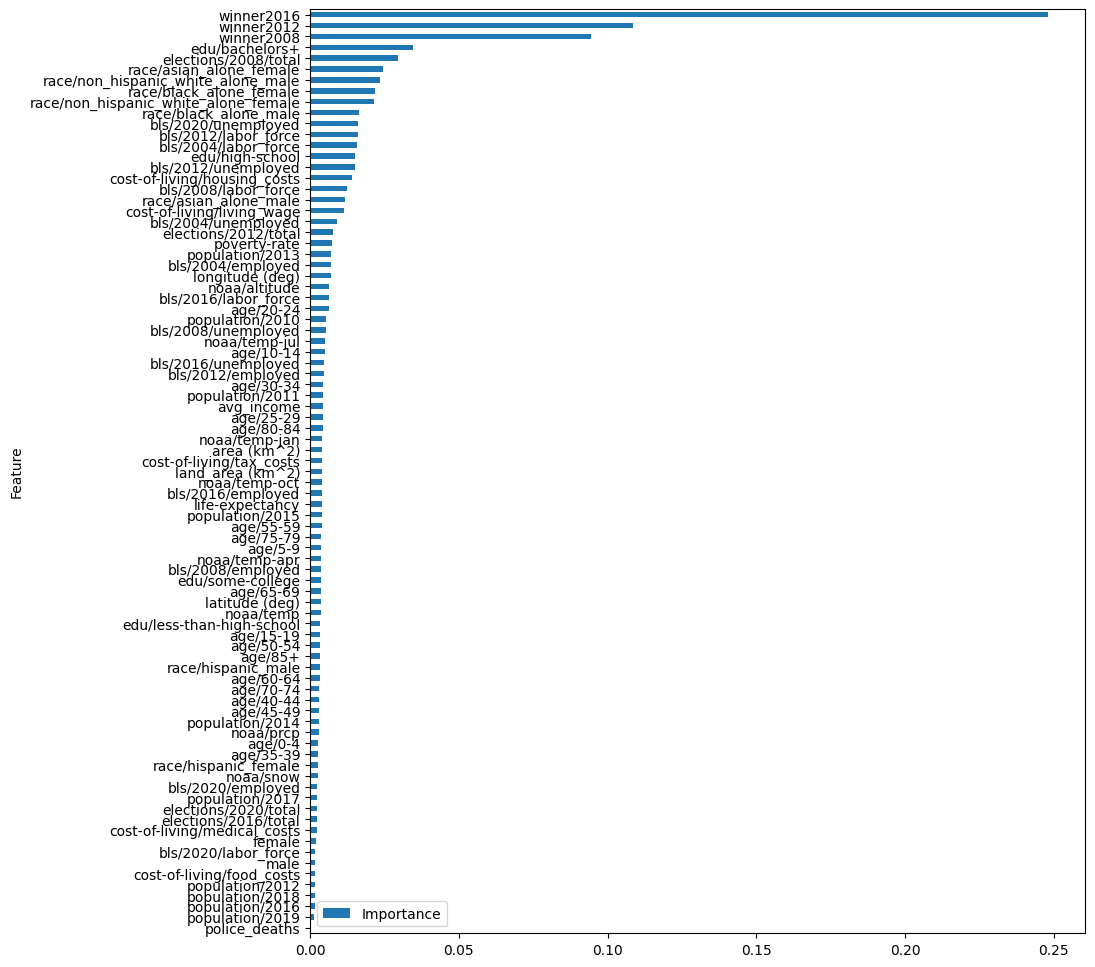

In [102]:
pd.DataFrame({'Feature':X_test_with_elections.columns,
              'Importance':search_rf_withelections.best_estimator_.feature_importances_}).sort_values('Importance', ascending=True).plot(x='Feature', y='Importance', kind='barh', figsize=(10, 12))

This time, the top three features are just the previous elections, with 2016 being by far ranked the highest. Then again we have that bachelors+ column that has been consistently showing up as important. Then the total election turnout in 2008, then race columns. 

# Misclassified Counties

In [103]:
misclassified.drop(columns=['name','state']).sum()

Copy2016                           15
Plain Logistic                     36
Plain Logistic with elections      23
Plain Logistic only elections      15
Logistic CV                        36
Logistic CV with elections         21
Decision Tree                      57
Decision Tree with Elections       26
Decision Tree CV                   44
Decision Tree CV with elections    23
Random Forest                      36
Random Forest with elections       16
dtype: int64

In terms of the number of misclassifications (not paying attention to which class is misclassified), nothing beats just copying the 2016 election (15 misclassifications). That's tied with the model where I used logistic regression on only the election columns.

Second place with only 16 misclassifications is using random forest  including elections.
Third place with 21 misclassifications is the Logistic CV with all the features (including previous elections), then with 23 misclassifications, plain logistic with elections tied with decision tree with elections.

Without including information from previous elections, it seems that the best I could do is 36 misclassifications, which is Plain logistic, logistic with cross validation, and random forest. 

Are there some counties that are more prone to misclassification?

In [104]:
misclassified['num_misclass'] = misclassified.drop(columns=['name','state']).sum(axis=1)

<Axes: >

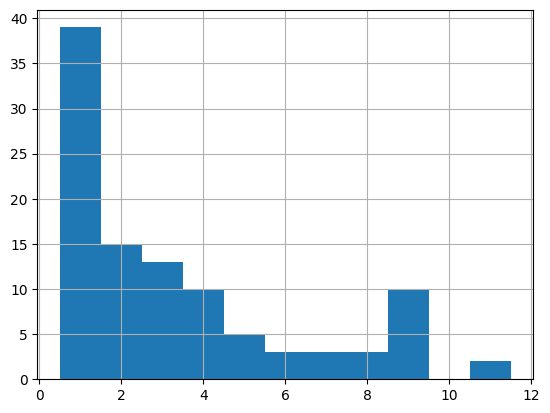

In [105]:
misclassified[misclassified['num_misclass']>0]['num_misclass'].hist(bins=np.linspace(0.5,11.5,12))

Looks like most often the counties are just misclassified by one or two of the models. However, there are a few counties that are repeatedly misclassified, although none were always misclassified. It might be worth looking into what those counties were, if there are any characteristics they share in common, and if they were counties that were suprising to anyone back in 2020.

In [109]:
misclassified.sort_values(by='num_misclass',ascending=False).head(15)

name state  Copy2016  Plain Logistic  \
2933     talbot county    MD      True            True   
1445    chaffee county    CO      True            True   
2123     orange county    NY     False            True   
2072    suffolk county    NY     False            True   
319        hays county    TX      True           False   
1432    alamosa county    CO      True            True   
2764   monmouth county    NJ     False            True   
2598    kendall county    IL      True           False   
403      collin county    TX     False            True   
1134     marion county    OR      True           False   
304     kleberg county    TX      True            True   
1247     warren county    MS      True           False   
410      denton county    TX     False            True   
2430      teton county    ID      True           False   
3092  penobscot county    ME     False            True   

      Plain Logistic with elections  Plain Logistic only elections  \
2933                           True                           True   
1445                           True                           True   
2123                           True                          False   
2072                           True                          False   
319                            True                           True   
1432                           True                           True   
2764                           True                          False   
2598                           True                           True   
403                            True                          False   
1134                           True                           True   
304                            True                           True   
1247                           True                           True   
410                            True                          False   
2430                           True                           True   
3092                           True                          False   

      Logistic CV  Logistic CV with elections  Decision Tree  \
2933         True                        True          False   
1445         True                        True          False   
2123         True                        True           True   
2072         True                        True           True   
319         False                        True           True   
1432         True                        True          False   
2764         True                        True           True   
2598        False                        True           True   
403          True                        True           True   
1134        False                        True           True   
304          True                        True          False   
1247        False                        True           True   
410          True                        True           True   
2430        False                        True          False   
3092         True                        True           True   

      Decision Tree with Elections  Decision Tree CV  \
2933                          True              True   
1445                          True              True   
2123                          True             False   
2072                         False              True   
319                          False              True   
1432                          True             False   
2764                         False              True   
2598                         False              True   
403                           True              True   
1134                         False              True   
304                           True             False   
1247                          True              True   
410                          False              True   
2430                          True              True   
3092                          True              True   

      Decision Tree CV with elections  Random 

I don't have quite enough domain knowledge of elections and these counties to have any insights jump out at me about what makes these difficult to predict, though I note that several of these ones that are most misclassified are also misclassified by assuming they'd vote the same way in 2016. 

And I notice that #13 is my county, Denton County! I'm not actually super surprised that it is difficult for my models to predict because the city of Denton is a lot more progressive than the surrounding county so there's some drastic differences even within the county.

# Summary of Key Findings and Insights

I used three main techniques for creating models with this data: logistic regression, decision trees, and random forest. Within each type of model, I used grid search cross validation to tune hyperparameters among several different options. I also explored how these models performed on a set of data that included previous election winners and then one that did not include previous election winners.

In [110]:
model_metrics

Copy_2016  Plain Logistic  Plain Logistic with elections  \
Accuracy    0.975923        0.942215                       0.963082   
Precision   0.979381        0.833333                       0.889908   
Recall      0.879630        0.833333                       0.898148   
F1Score     0.926829        0.833333                       0.894009   
AUC         0.937873        0.899191                       0.937424   

           Plain Logistic only elections  Logistic CV  \
Accuracy                        0.975923     0.942215   
Precision                       0.979381     0.815789   
Recall                          0.879630     0.861111   
F1Score                         0.926829     0.837838   
AUC                             0.937873     0.910167   

           Logistic CV with elections  Decision Tree  \
Accuracy                     0.966292       0.908507   
Precision                    0.891892       0.762887   
Recall                       0.916667       0.685185   
F1Score                      0.904110       0.721951   
AUC                          0.946683       0.820262   

           Decision Tree with elections  Decision Tree CV  \
Accuracy                       0.958266          0.929374   
Precision                      0.894231          0.840426   
Recall                         0.861111          0.731481   
F1Score                        0.877358          0.782178   
AUC                            0.919876          0.851178   

           Decision Tree CV with elections  Random Forest  \
Accuracy                          0.963082       0.942215   
Precision                         0.920792       0.875000   
Recall                            0.861111       0.777778   
F1Score                           0.889952       0.823529   
AUC                               0.922789       0.877238   

           Random Forest with Elections  
Accuracy                       0.974318  
Precision                      0.933962  
Recall                         0.916667  
F1Score                        0.925234  
AUC                            0.951537

In terms of model metrics as determined by the test set (printed above), the highest across the board is using random forest including previous election years. This model also had the lowest number of misclassified counties in the test set. It has a slightly lower precision but higher recall than just copying the 2016 election column. 

While the random forest model with the election columns was the best on prediction, it was also useful to look across multiple models to see some common features that kept coming up. Two features jumped out at me that were found to be important by several models:
- The fraction of white males in the population 
- The percentage of the population with Bachelors+ education

Other race/gender columns also showed up quite often, and surprisingly the Age 10-14 column showed up a couple of times (but not consistently in all models).

# Next Steps

There were some common struggles in all of these models, particularly in recall (getting all the Dem counties predicted). That weakness could by applying some of the resampling techniques to create a more balanced set of data (downsampling, upsampling, combinantion of both)

None of the models did much better than just copying 2016. They were still useful for drawing some insights on correlated factors. I could try including additional features, such as the health and covid columns that might be interesting. I could also introduce some combinations of columns, as it would make sense that the features can be interconnected in various ways that would contribute to voting patterns. 

I would be interested in focusing on a different classification question: Did the county change its majority from 2016 to 2020? Do those counties that flipped have anything in common? (Or four classes: voted Dem both times, voted GOP both times, flipped from Dem to GOP, flipped from GOP to Dem) This would be a very imbalanced data set, so I would need to apply resampling techniques. 